In [1]:
from torch_geometric.datasets import MoleculeNet
import torch
import numpy as np
import pandas as pd
from sklearn import metrics

## Import Dataset

In [2]:
data = MoleculeNet(root=".", name="bace")
data = data.shuffle()

In [3]:
#Specify device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## Set Hyperparameters

In [4]:
import best_config

#Get Model Parameters
hyperparameters = eval('best_config.'+best_config.GLOBALPARAMETERS['model_this_run']+'_HYPERPARAMETERS')
train_size = best_config.GLOBALPARAMETERS['train_size']
valid_size = train_size + best_config.GLOBALPARAMETERS['valid_size']


model_params = hyperparameters
model_params['feature_size'] = data.num_features
model_params["edge_dim"] = data[0].edge_attr.shape[1]

## Define Model

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [6]:
import models
print("Loading model...")

#Create instance of model
model = eval('models.'+best_config.GLOBALPARAMETERS['model_this_run']+'(model_params)')
print(model)
print(count_parameters(model))

Loading model...
GCN(
  (conv_layers): ModuleList(
    (0): GCNConv(1024, 1024)
    (1): GCNConv(1024, 1024)
  )
  (initial_conv): GCNConv(9, 1024)
  (gnn_dropout): Dropout(p=0.0472, inplace=False)
  (linear_dropout): Dropout(p=0.0413, inplace=False)
  (linear): Linear(in_features=2048, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)
2175041


In [7]:
model = model.to(device)

## Training Loop

In [8]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=model_params['learning_rate'])  

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
train_loader = DataLoader(data[:int(data_size * train_size)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
valid_loader = DataLoader(data[int(data_size * train_size):int(data_size * valid_size)], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * valid_size):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(loader):
    model.train()
    # Enumerate over the data
    final_loss = 0
    for batch in loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      if model_params['has_edge_info']:
          pred = model(batch.x.float(),
                        batch.edge_attr.float(), 
                        batch.edge_index, 
                        batch.batch)
      else:
          pred = model(batch.x.float(), 
                        batch.edge_index, 
                        batch.batch)
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)
      final_loss += loss.item()
      loss.backward()
      # Update using the gradients
      optimizer.step()   
    return final_loss / len(loader)
  
def evaluate(data_loader):
        model.eval()
        final_loss = 0
        for batch in data_loader:
            batch.to(device)
            if model_params['has_edge_info']:
                pred = model(batch.x.float(),
                                batch.edge_attr.float(), 
                                batch.edge_index, 
                                batch.batch)
            else:
                pred = model(batch.x.float(), 
                                batch.edge_index, 
                                batch.batch)
            loss = loss_fn(pred, batch.y)  
            final_loss += loss.item()
        return final_loss / len(data_loader)

def test(data_loader):   
    model.eval()
    true_values = []
    predictions = []
    with torch.no_grad():
        for batch in data_loader:
            batch.to(device)
            if model_params['has_edge_info']:
                pred = model(batch.x.float(),
                                batch.edge_attr.float(), 
                                batch.edge_index, 
                                batch.batch)
            else:
                pred = model(batch.x.float(), 
                                batch.edge_index, 
                                batch.batch)
            true_values += batch.y.tolist()
            predictions += pred.tolist()
    return metrics.accuracy_score(true_values,predictions)

In [9]:
print("Starting training...")
for epoch in range(300):
    loss = train(train_loader)
    val_loss = evaluate(valid_loader)
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train Loss {loss} | Valid Loss {val_loss}")

Starting training...
Epoch 0 | Train Loss 0.7002623379230499 | Valid Loss 0.7027594149112701
Epoch 10 | Train Loss 0.6806463599205017 | Valid Loss 0.697656899690628
Epoch 20 | Train Loss 0.669879212975502 | Valid Loss 0.6830691993236542
Epoch 30 | Train Loss 0.6465104669332504 | Valid Loss 0.7489508986473083
Epoch 40 | Train Loss 0.6259019672870636 | Valid Loss 0.6362908780574799
Epoch 50 | Train Loss 0.5659184008836746 | Valid Loss 0.7503137588500977
Epoch 60 | Train Loss 0.563387081027031 | Valid Loss 0.5444695502519608
Epoch 70 | Train Loss 0.5211610347032547 | Valid Loss 0.740913450717926
Epoch 80 | Train Loss 0.5220866799354553 | Valid Loss 0.595171183347702
Epoch 90 | Train Loss 0.5009714066982269 | Valid Loss 0.6409857869148254
Epoch 100 | Train Loss 0.4907456710934639 | Valid Loss 0.6002238094806671
Epoch 110 | Train Loss 0.5055464655160904 | Valid Loss 0.6675074100494385
Epoch 120 | Train Loss 0.45982733368873596 | Valid Loss 0.6593393087387085
Epoch 130 | Train Loss 0.4628800

## Evaluate on the Test Set

In [19]:
model.eval()
# Analyze the results for one batch
true_values = []
predictions = []
with torch.no_grad():
    for batch in test_loader:
        batch.to(device)
        if model_params['has_edge_info']:
            pred = model(batch.x.float(),
                            batch.edge_attr.float(), 
                            batch.edge_index, 
                            batch.batch)
        else:
            pred = model(batch.x.float(), 
                            batch.edge_index, 
                            batch.batch)
        true_values += batch.y.tolist()
        predictions += pred.tolist()
df = pd.DataFrame({'y_pred':predictions,'y_real':true_values})
df = df.applymap(lambda x : x[0])
df

,y_pred,y_real
0,0.151423,0.0
1,0.046310,0.0
2,0.025605,0.0
3,0.695948,0.0
4,0.003683,0.0
...,...,...
1206,0.816632,1.0
1207,0.235131,1.0
1208,0.003267,0.0
1209,0.014795,0.0


## Model Evaluation

In [20]:
output = df["y_pred"].apply(lambda x: int(round(x,0)))
output
binary_results = df.applymap(lambda x : int(round(x,0)))
binary_results

,y_pred,y_real
0,0,0
1,0,0
2,0,0
3,1,0
4,0,0
...,...,...
1206,1,1
1207,0,1
1208,0,0
1209,0,0


In [12]:
report = metrics.classification_report(binary_results["y_real"],binary_results["y_pred"], output_dict=True)
report_string = metrics.classification_report(binary_results["y_real"],binary_results["y_pred"], output_dict=False)
report

accuracy = metrics.accuracy_score(binary_results["y_real"],binary_results["y_pred"])
f1 = metrics.f1_score(binary_results["y_real"],binary_results["y_pred"])
precision = metrics.precision_score(binary_results["y_real"],binary_results["y_pred"])
recall = metrics.recall_score(binary_results["y_real"],binary_results["y_pred"])
roc_auc = metrics.roc_auc_score(binary_results["y_real"],binary_results["y_pred"])
tn, fp, fn, tp = metrics.confusion_matrix(binary_results["y_real"],binary_results["y_pred"], labels=[0,1]).ravel()
specificity = tn / (tn+fp)
averageprecision = metrics.average_precision_score(df["y_real"].to_list(),df["y_pred"].to_list())

results = {
    'Accuracy':accuracy,
    'F1': f1,
    'Precision': precision,
    'Recall': recall,
    'ROCAUC': roc_auc,
    'Specificity': specificity,
    'Average Precision': averageprecision,
    'TN': tn,
    'FP': fp,
    'FN': fn,
    "TP": tp,
}

summary = pd.DataFrame([results])
filepath = '/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/results/'
#summary.to_csv(filepath + best_config.GLOBALPARAMETERS['model_this_run']+'summary.csv')
summary


,Accuracy,F1,Precision,Recall,ROCAUC,Specificity,Average Precision,TN,FP,FN,TP
0,0.721718,0.673133,0.705285,0.643785,0.714005,0.784226,0.732605,527,145,192,347


### Confusion Matrix

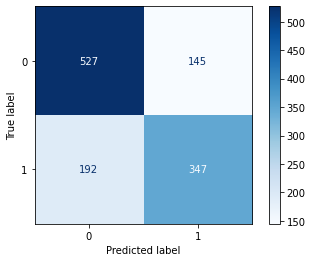

In [13]:
import matplotlib.pyplot as plt
labels = [0,1]
cm = metrics.confusion_matrix(output,df["y_real"])
metrics.ConfusionMatrixDisplay.from_predictions(binary_results["y_real"],binary_results["y_pred"], cmap='Blues')

filepath = '/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/results/'
plt.savefig(filepath + best_config.GLOBALPARAMETERS['model_this_run'] + 'confusion_matrix.jpeg', bbox_inches='tight',dpi=100)

### ROC Curve

In [14]:
r_fpr, r_tpr, thresholds = metrics.roc_curve(df["y_real"].to_list(),df["y_pred"].to_list())

roc_curve_data = pd.DataFrame({'r_fpr': r_fpr, 'r_tpr': r_tpr, 'thresholds': thresholds})

filepath = '/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/results/'
roc_curve_data.to_csv(filepath + best_config.GLOBALPARAMETERS['model_this_run']+'rocdata.csv')

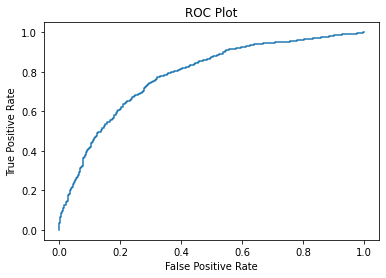

In [15]:
import matplotlib.pyplot as plt

plt.plot(r_fpr, r_tpr)
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

filepath = '/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/results/'
plt.savefig(filepath + best_config.GLOBALPARAMETERS['model_this_run'] + 'roc_curve.jpeg', bbox_inches='tight', dpi=100)

In [16]:
def evaluate_threshold(threshold):
    print('Sensitivity:', r_tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - r_fpr[thresholds > threshold][-1])

evaluate_threshold(0.3)

Sensitivity: 0.7569573283858998
Specificity: 0.6875


## PR Curve

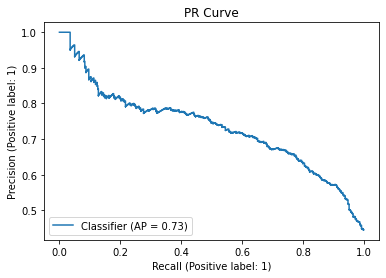

In [17]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(df["y_real"].to_list(),df["y_pred"].to_list())
metrics.PrecisionRecallDisplay.from_predictions(df["y_real"].to_list(),df["y_pred"].to_list())

plt.title('PR Curve')

filepath = '/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/results/'
plt.savefig(filepath + best_config.GLOBALPARAMETERS['model_this_run'] + 'pr_curve.jpeg', bbox_inches='tight', dpi=100)

In [18]:
from sklearn.preprocessing import binarize
threshold = 0.3
predictions_with_new_threshold = binarize(df["y_pred"].to_numpy().reshape(-1,1), threshold = threshold)
predictions_with_new_threshold

array([[0.],
       [0.],
       [1.],
       ...,
       [0.],
       [1.],
       [0.]])